# Unsupervised Models

## Preparing the data

### Libraries Imports

In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from preprocessing.dataset import Dataset

: 

### Load the Datasets

In [ ]:
# Scrapped dataset
scr_dataset = Dataset("Datasets/olympics_athletes_1_200000_new.csv")

# Kaggle dataset
kgl_dataset = Dataset("Datasets/kaggle/athlete_events_new.csv")

### Load the Labels

In [13]:
# Load the labels corresponding to the encoded values
with open("Datasets/olympics_athletes_1_200000.json", "r") as file:
    dic = json.load(file)

Now that we have the corresponding labels, we can do some prints. Below is an example with the medals labels.

In [33]:
medal_type, medal_code = dic["Medal"]
medal_type = np.array(medal_type)
medal_code = np.array(medal_code)

print(medal_type)
print(medal_code)

sport_type, sport_code = dic["Sport"]
sport_type = np.array(sport_type)
sport_code = np.array(sport_code)

noc_type, noc_code = dic["NOC"]
noc_type = np.array(noc_type)
noc_code = np.array(noc_code)

sex_type, sex_code = dic["Sex"]
sex_type = np.array(sex_type)
sex_code = np.array(sex_code)

['None' 'Bronze' 'Silver' 'Gold']
[2 0 3 1]


## Gaussian Mixture Model (GMM)

### Determining the number of components

In [3]:
scr_bics = []
scr_aics = []
kgl_bics = []
kgl_aics = []

scr_data = scr_dataset.datapoints.to_numpy()
kgl_data = kgl_dataset.datapoints.to_numpy()

for k in range(1, 101, 3):
    print(f"Fitting GMM with {k} components")
    gmm = GaussianMixture(n_components=k)
    gmm.fit(scr_data)
    
    scr_bics.append(gmm.bic(scr_data))
    scr_aics.append(gmm.aic(scr_data))
    
    gmm = GaussianMixture(n_components=k)
    gmm.fit(kgl_data)
    
    kgl_bics.append(gmm.bic(kgl_data))
    kgl_aics.append(gmm.aic(kgl_data))


Fitting GMM with 1 components
Fitting GMM with 4 components
Fitting GMM with 7 components
Fitting GMM with 10 components
Fitting GMM with 13 components
Fitting GMM with 16 components
Fitting GMM with 19 components
Fitting GMM with 22 components
Fitting GMM with 25 components
Fitting GMM with 28 components
Fitting GMM with 31 components
Fitting GMM with 34 components
Fitting GMM with 37 components
Fitting GMM with 40 components
Fitting GMM with 43 components
Fitting GMM with 46 components
Fitting GMM with 49 components
Fitting GMM with 52 components
Fitting GMM with 55 components
Fitting GMM with 58 components
Fitting GMM with 61 components
Fitting GMM with 64 components
Fitting GMM with 67 components
Fitting GMM with 70 components
Fitting GMM with 73 components
Fitting GMM with 76 components
Fitting GMM with 79 components
Fitting GMM with 82 components
Fitting GMM with 85 components
Fitting GMM with 88 components
Fitting GMM with 91 components
Fitting GMM with 94 components
Fitting GMM

In [4]:
# Save the AICs / BICs because it's very long to run the previous cell
np.save("Figures/scr_bics.npy", scr_bics)
np.save("Figures/scr_aics.npy", scr_aics)
np.save("Figures/kgl_bics.npy", kgl_bics)
np.save("Figures/kgl_aics.npy", kgl_aics)

In [ ]:
# Load the AICs / BICs in case of a kernel crash
scr_bics = np.load("Figures/scr_bics.npy")
scr_aics = np.load("Figures/scr_aics.npy")
kgl_bics = np.load("Figures/kgl_bics.npy")
kgl_aics = np.load("Figures/kgl_aics.npy")

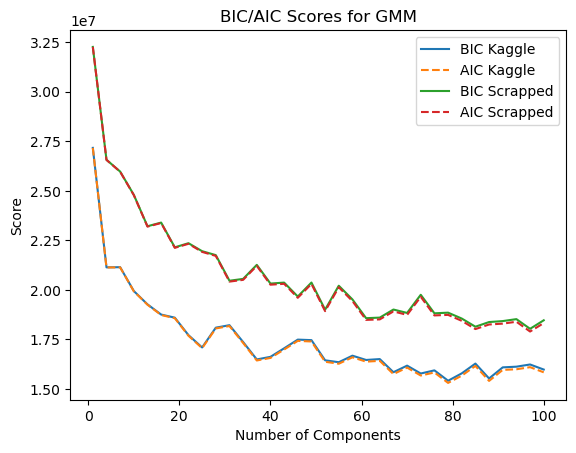

In [5]:
comps = np.arange(1, 101, 3)

plt.plot(comps, kgl_bics, label='BIC Kaggle')
plt.plot(comps, kgl_aics, '--', label='AIC Kaggle')
plt.plot(comps, scr_bics, label='BIC Scrapped')
plt.plot(comps, scr_aics, '--', label='AIC Scrapped')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC/AIC Scores for GMM')
plt.legend()
plt.show()

### Reduce the number of columns

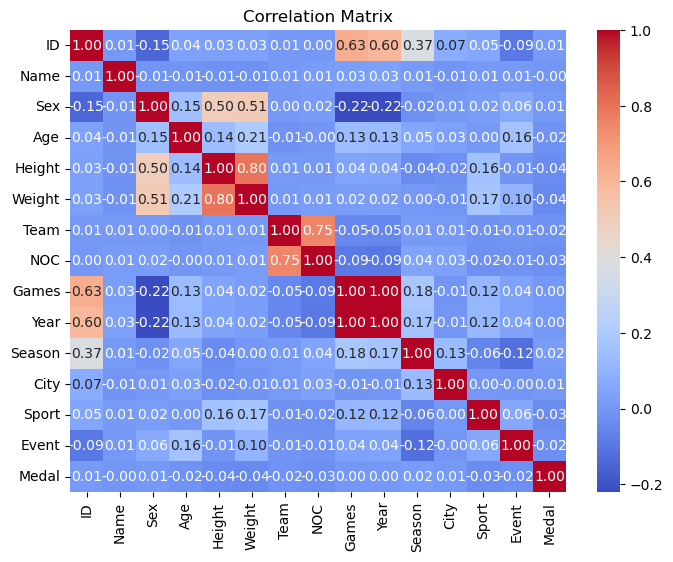

In [6]:
corr_mat = scr_dataset.get_correlation()

Remove the highly correlated columns

In [7]:
selected_columns = set(scr_dataset.datapoints.columns)
correlation_threshold = 0.7

for i in range(len(corr_mat.columns)):
    for j in range(i):
        if abs(corr_mat.iloc[i, j]) > correlation_threshold:
            colname_i = corr_mat.columns[i]
            colname_j = corr_mat.columns[j]
            
            # Remove one of the correlated columns
            if colname_i in selected_columns:
                selected_columns.remove(colname_j)

print(selected_columns)

{'Season', 'Weight', 'Age', 'Sport', 'Medal', 'NOC', 'Sex', 'City', 'Name', 'Year', 'ID', 'Event'}


After this step of keeping only columns with non highly correlated information, we can also remove more columns to reduce the dimensionality of the dataset and help the unsupervised models to learn better. If we want to regroup the athletes to understand what makes them good at one sport or one particular event, we can confidently remove some columns with our human knowledge that should not influence the results.

In [8]:
for col in ["Name", "ID", "City", "Year", "Season", "Event"]:
    selected_columns.remove(col)

print(selected_columns)

{'Weight', 'Age', 'Sport', 'Medal', 'NOC', 'Sex'}


Here we keep 6 columns, containing non highly correlated information about the athletes and their performance in a sport.

In [9]:
sub_df = scr_dataset.datapoints[list(selected_columns)]
sub_data = sub_df.to_numpy()

We can make an assumption on the number of components to fit with our GMM because of our a priori knowledge. Here we do a strong and biased assumption that we can fit one Gaussian per sport. We have 73 different sports in this dataset.

In [10]:
gmm = GaussianMixture(n_components=73)

In [11]:
gmm.fit(sub_data)
BIC = gmm.bic(sub_data)

print(f"BIC on the reduced data: {BIC:.2E}")

BIC on the reduced data: 1.70E+06


We can see here, that with a reduced number of columns, we have a lower BIC (~ 10%) for the same number of components (cf previous Figure). Let's now predict the results with this model.

In [12]:
cluster_labels = gmm.predict(sub_data)

Now that the model is trained, let's have a look at some visualizations.

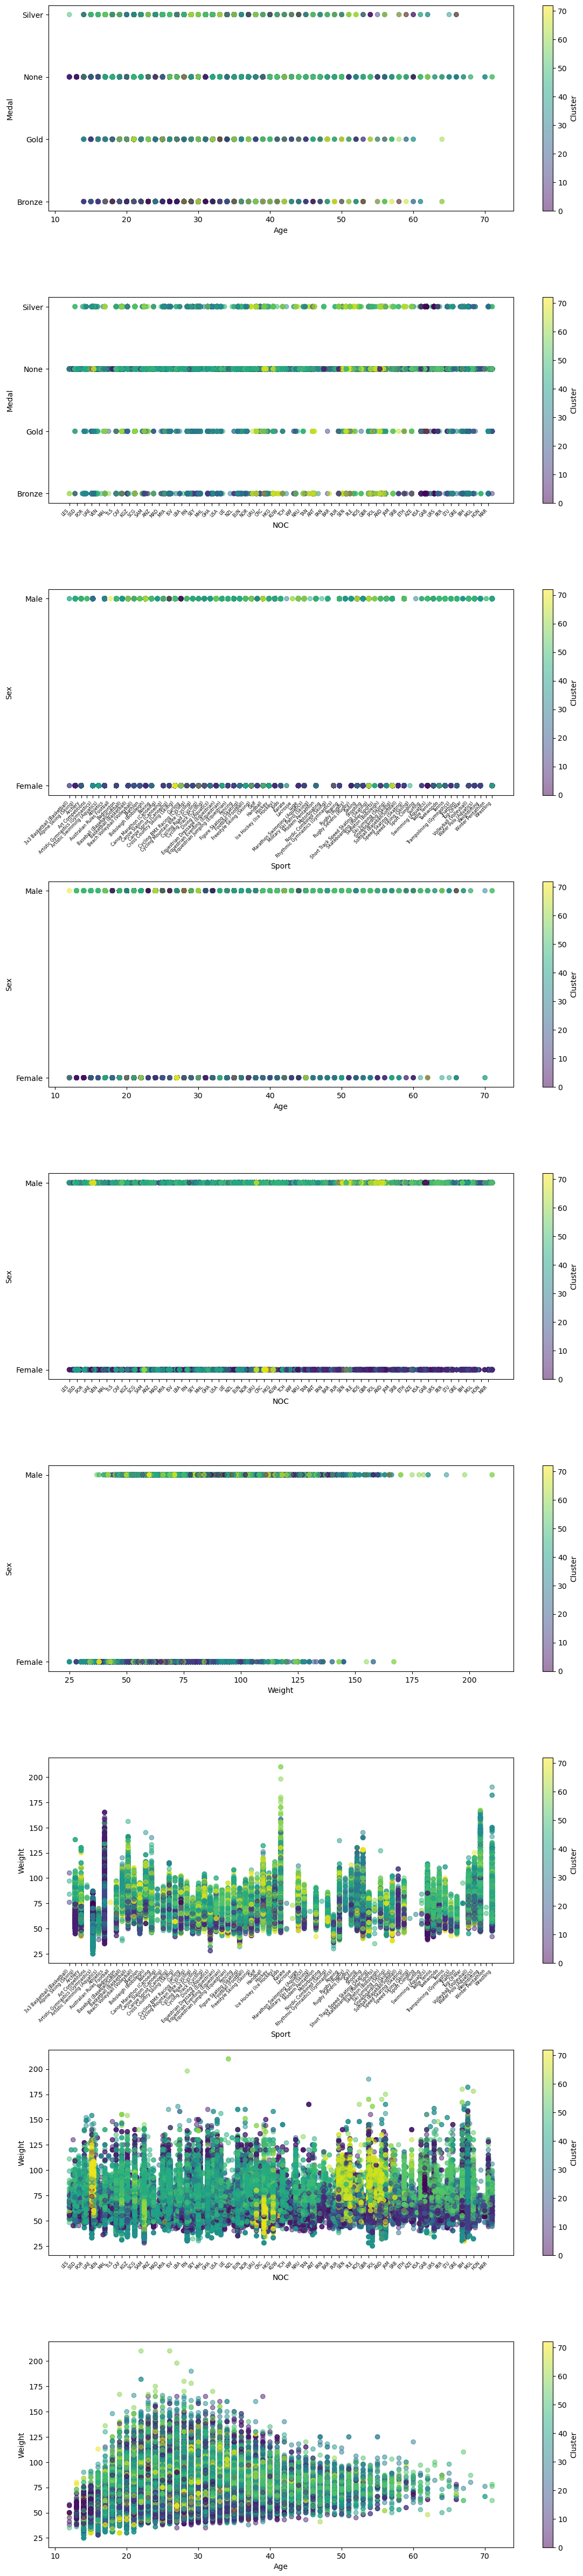

In [27]:
fig, axs = plt.subplots(9, 1, figsize=(12, 48))
ticks = np.arange(0, 73)

# Medal / Age
im0 = axs[0].scatter(sub_df["Age"], sub_df["Medal"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Medal")
axs[0].set_yticks(medal_code)
axs[0].set_yticklabels(medal_type)
fig.colorbar(im0, label="Cluster")

# Medal / NOC
sub_noc_code = np.arange(0, 227, 4)
sub_noc_type = noc_type[sub_noc_code]
im1 = axs[1].scatter(sub_df["NOC"], sub_df["Medal"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[1].set_xlabel("NOC")
axs[1].set_xticks(sub_noc_code)
axs[1].set_xticklabels(sub_noc_type, rotation=45, ha="right", fontsize="xx-small")
axs[1].set_ylabel("Medal")
axs[1].set_yticks(medal_code)
axs[1].set_yticklabels(medal_type)
fig.colorbar(im1, label="Cluster")

# Sex / Sport
im2 = axs[2].scatter(sub_df["Sport"], sub_df["Sex"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[2].set_xlabel("Sport")
axs[2].set_xticks(sport_code)
axs[2].set_xticklabels(sport_type, rotation=45, ha="right", fontsize="xx-small")
axs[2].set_ylabel("Sex")
axs[2].set_yticks(sex_code)
axs[2].set_yticklabels(sex_type)
fig.colorbar(im2, label="Cluster")

# Sex / Age
im3 = axs[3].scatter(sub_df["Age"], sub_df["Sex"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[3].set_xlabel("Age")
axs[3].set_ylabel("Sex")
axs[3].set_yticks(sex_code)
axs[3].set_yticklabels(sex_type)
fig.colorbar(im3, label="Cluster")

# Sex / NOC
im4 = axs[4].scatter(sub_df["NOC"], sub_df["Sex"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[4].set_xlabel("NOC")
axs[4].set_xticks(sub_noc_code)
axs[4].set_xticklabels(sub_noc_type, rotation=45, ha="right", fontsize="xx-small")
axs[4].set_ylabel("Sex")
axs[4].set_yticks(sex_code)
axs[4].set_yticklabels(sex_type)
fig.colorbar(im4, label="Cluster")

# Sex / Weight
im5 = axs[5].scatter(sub_df["Weight"], sub_df["Sex"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[5].set_xlabel("Weight")
axs[5].set_ylabel("Sex")
axs[5].set_yticks(sex_code)
axs[5].set_yticklabels(sex_type)
fig.colorbar(im5, label="Cluster")

# Weight / Sport
im6 = axs[6].scatter(sub_df["Sport"], sub_df["Weight"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[6].set_xlabel("Sport")
axs[6].set_xticks(sport_code)
axs[6].set_xticklabels(sport_type, rotation=45, ha="right", fontsize="xx-small")
axs[6].set_ylabel("Weight")
fig.colorbar(im6, label="Cluster")

# Weight / NOC
im7 = axs[7].scatter(sub_df["NOC"], sub_df["Weight"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[7].set_xlabel("NOC")
axs[7].set_xticks(sub_noc_code)
axs[7].set_xticklabels(sub_noc_type, rotation=45, ha="right", fontsize="xx-small")
axs[7].set_ylabel("Weight")
fig.colorbar(im7, label="Cluster")

# Weight / Age
im8 = axs[8].scatter(sub_df["Age"], sub_df["Weight"], c=cluster_labels, cmap='viridis', alpha=0.5)
axs[8].set_xlabel("Age")
axs[8].set_ylabel("Weight")
fig.colorbar(im8, label="Cluster")

fig.tight_layout(pad=1.5)

All these plots show that even by reducing the size of the data and setting a known number of clusters, it is still really hard for the GMM model to clusterize the data.

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

Scale the data and fit a DBSCAN model.

In [28]:
encoded = pd.get_dummies(sub_df)

scaler = StandardScaler()
scaled = scaler.fit_transform(encoded)

dbscan = DBSCAN(eps=1.5)

clusters = dbscan.fit_predict(scaled)
clust_inds = np.unique(clusters)

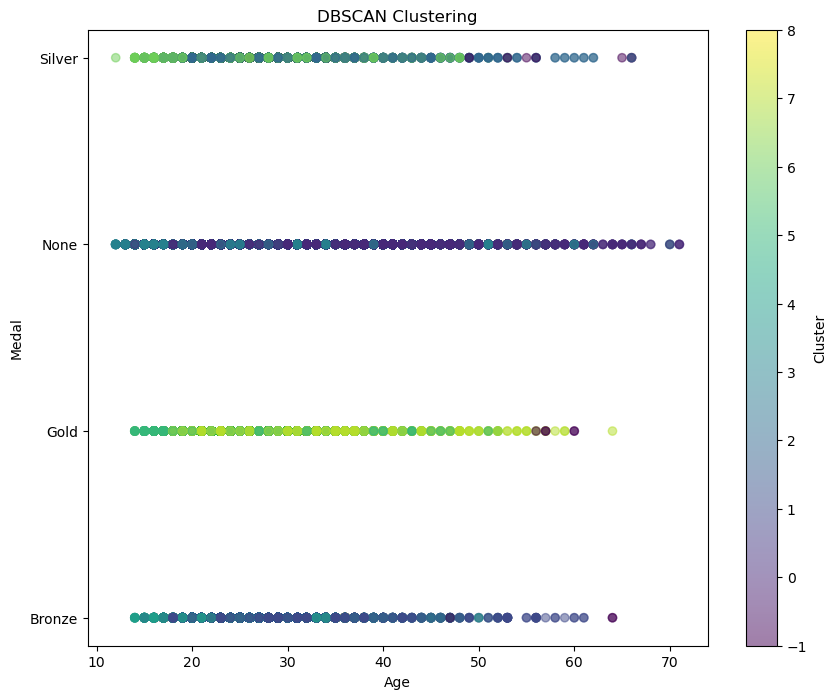

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(encoded['Age'], encoded['Medal'], c=clusters, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.yticks(medal_code, medal_type)
plt.title('DBSCAN Clustering')
plt.xlabel('Age')
plt.ylabel('Medal')
plt.show()

The DBSCAN model fitted 8 clusters labeled from 0 to 8, and put outliers in the cluster labeled -1.

We can see on this plot that the clusters kinda reflect the results, but let's verify it with some statistics.

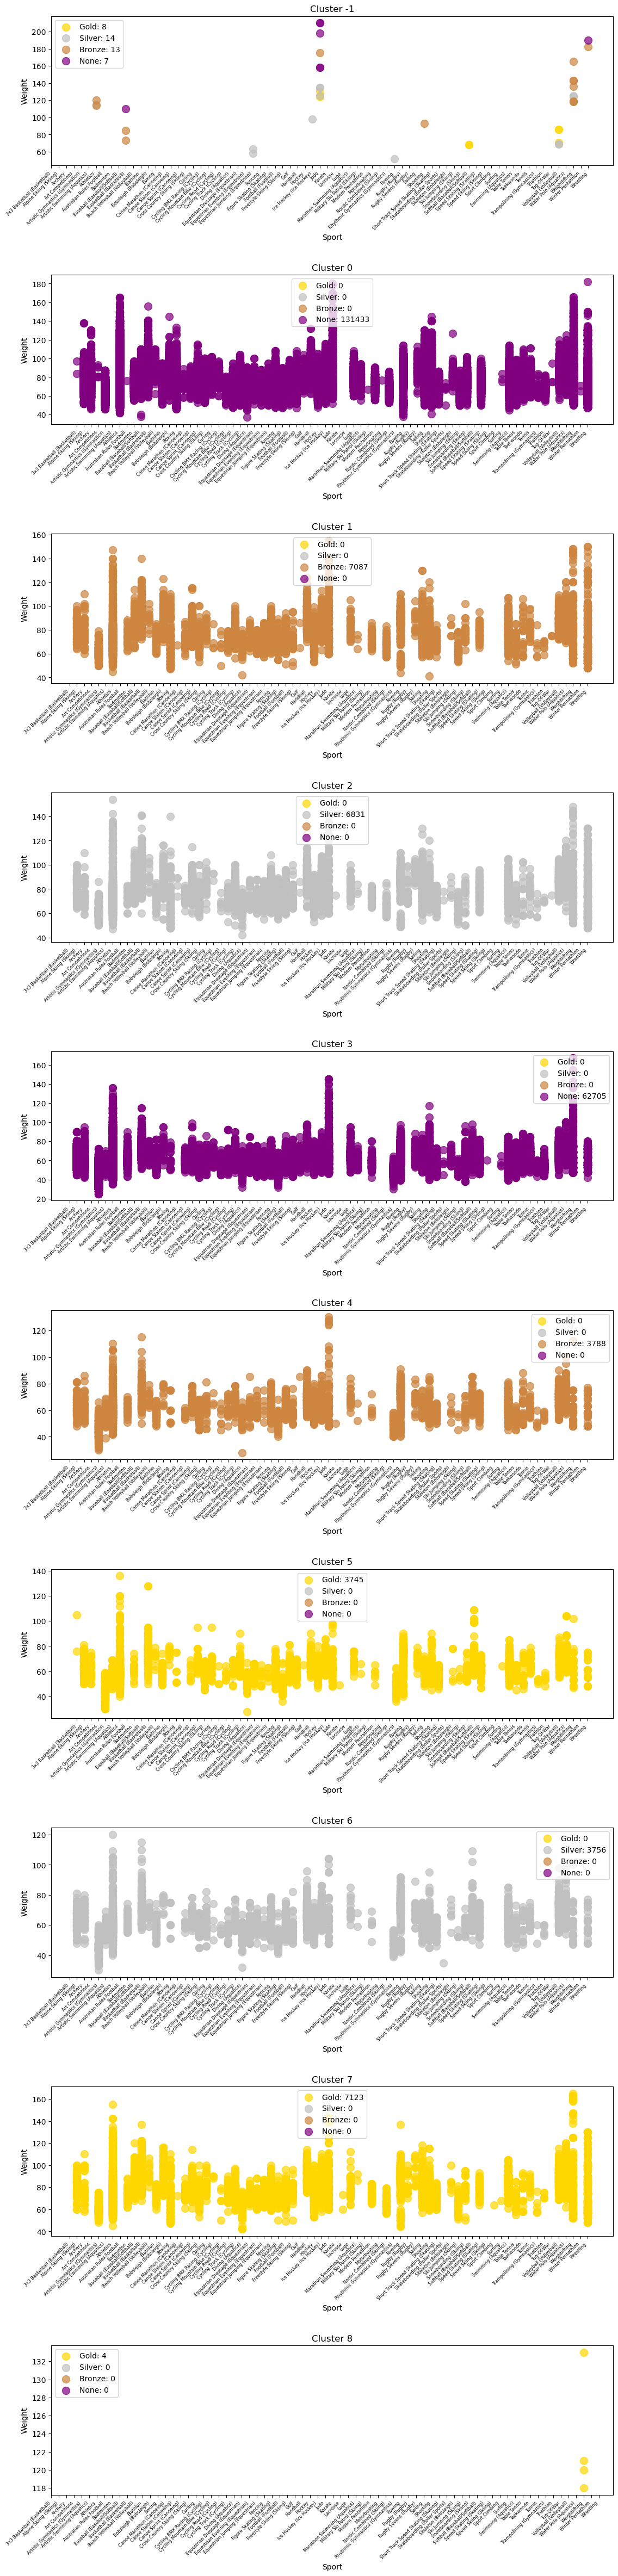

In [36]:
fig, axs = plt.subplots(10, 1, figsize=(12, 48))
medal_colors = {1: 'gold', 3: 'silver', 0: 'peru', 2: 'purple'}
ticks = np.arange(0, 73)
sports = [sport_type[np.nonzero(sport_code == tick)[0][0]] for tick in ticks]

for idx, (ax, clust_ind) in enumerate(zip(axs.flatten(), clust_inds)):
    
    tmp = encoded.loc[clusters == clust_ind, :]
    
    for code, color in medal_colors.items():
        df = tmp[tmp["Medal"] == code]
        ax.scatter(
            df["Sport"],
            df["Weight"],
            color=color,
            label=f"{medal_type[np.nonzero(medal_code == code)[0][0]]}: {len(df)}",
            alpha=0.7,
            s=100,
            )
        
    ax.set_xlabel("Sport")
    ax.set_ylabel("Weight")
    ax.set_xticks(ticks)
    ax.set_xticklabels(sports, rotation=45, ha="right", fontsize="xx-small")
    ax.set_title(f"Cluster {clust_ind}")
    ax.legend()

fig.tight_layout(pad=3)

These plots show that the DBSCAN model created some clusters that are really good at predicting the given medal. If we have a new athlete with all the required information, we can look at which cluster he belongs, and then deduct the kind of medal he would get.